# 개,고양이 이미지 분류
데이터 : https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip

In [7]:
import numpy as np
import pandas as pd
import os,shutil,pathlib

In [8]:
dir1=pathlib.Path('data/train')
dir2=pathlib.Path('data/holdout')

In [9]:
def make_data(name,s_idx,e_idx):
    for cate in ('cat','dog'):
        dir=dir2/name/cate
        os.makedirs(dir)
        fnames=[f'{cate}.{i}.jpg'
               for i in range(s_idx,e_idx)]
        for fname in fnames:
            shutil.copyfile(src=dir1/fname,
                           dst=dir/fname)

In [193]:
make_data('train',s_idx=0,e_idx=1000)
make_data('valid',s_idx=1000,e_idx=1500)
make_data('test',s_idx=1500,e_idx=2500)

## 모델 생성

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
model=keras.Sequential()
model.add(keras.Input(shape=(180,180,3)))
model.add(keras.layers.Rescaling(1./255))
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                             input_shape=(180,180,3)))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 41, 41, 128)      

In [26]:
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics='accuracy')

## 이미지 읽기
batch size가 커질 수록 일반화 성능은 감소하는 경우가 있음.(작을수록 모델의 학습속도가 빠름)

In [27]:
from tensorflow.keras.utils import image_dataset_from_directory

tr_dt=image_dataset_from_directory(
    dir2/'train',
    image_size=(180,180),
    batch_size=32)

val_dt=image_dataset_from_directory(
    dir2/'valid',
    image_size=(180,180),
    batch_size=32)

te_dt=image_dataset_from_directory(
    dir2/'test',
    image_size=(180,180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [28]:
callbacks=[
    keras.callbacks.ModelCheckpoint(
    filepath='convnet.keras',
    save_best_only=True,
    monitor='val_loss'),
    keras.callbacks.EarlyStopping(patience=3)
]

In [29]:
his=model.fit(tr_dt,epochs=20,validation_data=val_dt,callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 91s 1s/step - loss: 0.7475 - accuracy: 0.5090 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 95s 2s/step - loss: 0.7015 - accuracy: 0.5675 - val_loss: 0.6640 - val_accuracy: 0.6170
Epoch 3/20
63/63 [==============================] - 94s 1s/step - loss: 0.6699 - accuracy: 0.6155 - val_loss: 0.6565 - val_accuracy: 0.6080
Epoch 4/20
63/63 [==============================] - 106s 2s/step - loss: 0.6349 - accuracy: 0.6510 - val_loss: 0.6823 - val_accuracy: 0.6090
Epoch 5/20
63/63 [==============================] - 94s 1s/step - loss: 0.6111 - accuracy: 0.6715 - val_loss: 0.6380 - val_accuracy: 0.6600
Epoch 6/20
63/63 [==============================] - 94s 1s/step - loss: 0.5547 - accuracy: 0.7230 - val_loss: 0.5618 - val_accuracy: 0.7320
Epoch 7/20
63/63 [==============================] - 99s 2s/step - loss: 0.5193 - accuracy: 0.7435 - val_loss: 0.5986 - val_accuracy: 0.7120
Epoch 8/20
63/63 [=

In [34]:
res=pd.DataFrame(his.history,columns=his.history.keys())

In [35]:
res

,loss,accuracy,val_loss,val_accuracy
0,0.747512,0.5090,0.699554,0.500
1,0.701541,0.5675,0.664002,0.617
2,0.669893,0.6155,0.656507,0.608
3,0.634903,0.6510,0.682335,0.609
4,0.611140,0.6715,0.638048,0.660
5,0.554739,0.7230,0.561807,0.732
6,0.519320,0.7435,0.598640,0.712
7,0.469116,0.7765,0.668426,0.700
8,0.413737,0.8145,0.685023,0.704


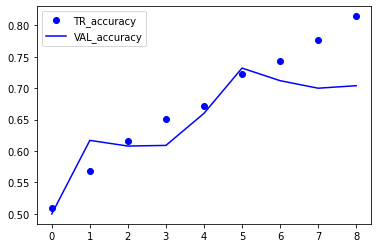

In [37]:
import matplotlib.pyplot as plt

plt.plot(res.index,res.accuracy,'bo',label='TR_accuracy')
plt.plot(res.index,res.val_accuracy,'b',label='VAL_accuracy')
plt.legend()

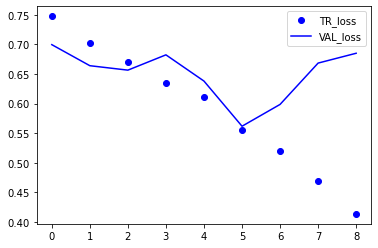

In [39]:
plt.plot(res.index,res.loss,'bo',label='TR_loss')
plt.plot(res.index,res.val_loss,'b',label='VAL_loss')
plt.legend()

6번 에포크에서 가장 성능이 좋음

In [49]:
print('훈련 데이터셋 정확도 : {0:0.3f}, 손실점수 {1:0.3f}'.format(res.accuracy[8],res.loss[8]))
print('검증 데이터셋 정확도 : {0:0.3f}, 손실점수 {1:0.3f}'.format(res.val_accuracy[8],res.val_loss[8]))

훈련 데이터셋 정확도 : 0.814, 손실점수 0.414
검증 데이터셋 정확도 : 0.704, 손실점수 0.685


In [41]:
best_model=keras.models.load_model('convnet.keras')

In [50]:
tr_eval=best_model.evaluate(te_dt)

63/63 [==============================] - 16s 248ms/step - loss: 0.5862 - accuracy: 0.7075


최종 테스트 성능은 정확도 약 71%를 얻어냄

In [51]:
print('테스트 데이터셋 정확도 : {0:0.3f}, 손실점수 {1:0.3f}'.format(tr_eval[1],tr_eval[0]))

테스트 데이터셋 정확도 : 0.707, 손실점수 0.586


# 데이터 증식을 이용한 분류 성능 향상
RandomFlip : 랜덤하게 이미지를 뒤집음 (horizontal_and_vertical)  
RandomRotation : 설정한 비율안에서 이미지를 회전함(0.0 ~ 1.0)  
RandomZoom : 설정한 범위 안에서 이미지를 확대하거나 축소함(0.0 ~ 1.0)

In [52]:
aug=keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])


## 증식한 이미지 출력

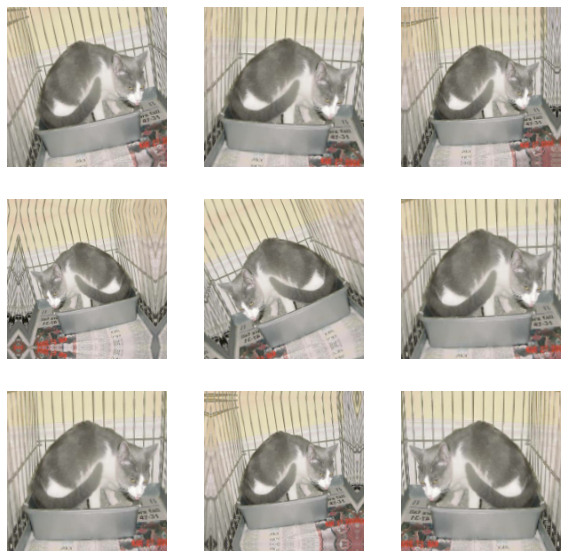

In [60]:
plt.figure(figsize=(10,10))
for img,_ in tr_dt.take(1):
    for i in range(9):
        aug_img=aug(img)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')

## 증식과 드롭아웃 포함 합성곱 모델링

In [72]:
model2=keras.Sequential()
model2.add(keras.Input(shape=(180,180,3)))
model2.add(keras.layers.RandomFlip('horizontal'))
model2.add(keras.layers.RandomRotation(0.1))
model2.add(keras.layers.RandomZoom(0.2))
model2.add(keras.layers.Rescaling(1./255))
model2.add(keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=2))
model2.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=2))
model2.add(keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=2))
model2.add(keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=2))
model2.add(keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(1,activation='sigmoid'))

In [73]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                

In [74]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics='accuracy')

In [79]:
import tensorflow
tensorflow.get_logger().setLevel('ERROR')

데이터 증식과 드롭아웃을 사용했으므로 과대적합이 늦게 일어날 것이기 때문에 에포크를 50으로 설정하고 훈련함

In [ ]:
callbacks2=[
    keras.callbacks.ModelCheckpoint(
    filepath='convnet_with_aug.keras',
    save_best_only=True,
    monitor='val_loss'),
    keras.callbacks.EarlyStopping(patience=2)
]

his2=model.fit(tr_dt,
              epochs=50,
              validation_data=val_dt,
              callbacks=callbacks2)